### Overview

[Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)  
This notebook does exploratory data analysis and feature engineering. The results are dumped to file for modeling.  
The task is to forecast the total amount of products sold in every shop for the test set. 

#### Exploratary Data Analysis
- Load and display data  

#### Data cleaning & Feature engineering
- Shop/Item_cat/Item preprocessing
- Aggregate data  
- Test data preprocessing
- Add Shop/Item_cat/Item feature
- Mean encoding
- Mean encoding for item_id and shop_id
- Add lag features
- Split into training and validation sets
- Hyperparameter tuning
- Ensembling
- Results Submission

In [78]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import time
import gc
warnings.filterwarnings('ignore')
%matplotlib inline 

from itertools import product
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook

import xgboost as xgb

for p in [np, pd, sns, xgb]:
    print (p.__name__, p.__version__)

numpy 1.16.2
pandas 0.24.2
seaborn 0.9.0
xgboost 0.90


In [2]:
# Function

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load and display data

In [2]:
train    = pd.read_csv('../How to Win a Data/competitive-data-science-final-project/sales_train.csv.gz')

shops           = pd.read_csv('../How to Win a Data/competitive-data-science-final-project/shops.csv')
item_cats = pd.read_csv('../How to Win a Data/competitive-data-science-final-project/item_categories.csv')
items           = pd.read_csv('../How to Win a Data/competitive-data-science-final-project/items.csv')

# set index to ID to avoid droping it later
test           = pd.read_csv('../How to Win a Data/competitive-data-science-final-project/test.csv').set_index('ID')
sample_subs = pd.read_csv('../How to Win a Data/competitive-data-science-final-project/sample_submission.csv')
#2013.1-2015.10


1.Sales Train date

In [3]:
print('\n# train\n')
print('-------------------------------top5_record------------------------------')
display(train.head())
print('---------------------------------describe------------------------------')
display(train.describe())
print('----------------shpae----------------')
print(train.shape)
print('----------------info----------------')
train.info()
print('----------------NaN-------')
print(train.isnull().sum())


# train

-------------------------------top5_record------------------------------


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


---------------------------------describe------------------------------


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


----------------shpae----------------
(2935849, 6)
----------------info----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
----------------NaN-------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000228532C3128>,
      dtype=object)

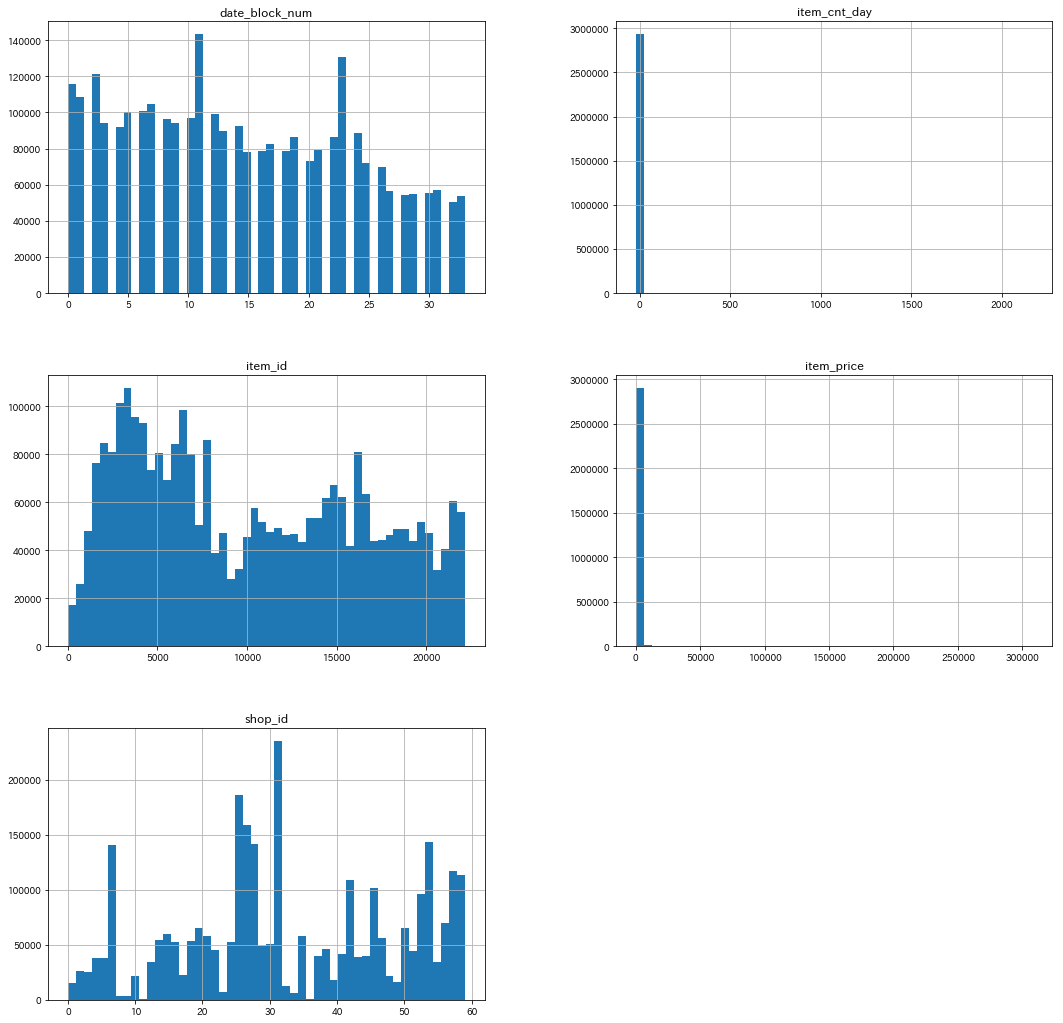

In [5]:
train_fig =  train.select_dtypes(include = ['float64', 'int64'])
train_fig.hist(figsize=(18, 18), bins=50, xlabelsize=9, ylabelsize=9)

2.Test Data

In [4]:
print('# test')
print('----------------top5_record----------------')
display(test.head())
print('----------------shpae----------------')
print(test.shape)
print('----------------info----------------')
test.info()
print('----------------NaN-------')
print(test.isnull().sum())

# test
----------------top5_record----------------


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


----------------shpae----------------
(214200, 2)
----------------info----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 2 columns):
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(2)
memory usage: 4.9 MB
----------------NaN-------
shop_id    0
item_id    0
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F101C52080>,
      dtype=object)

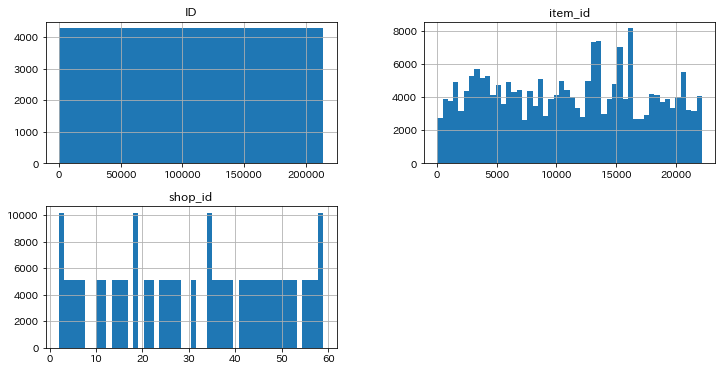

In [14]:
test_fig =  test.select_dtypes(include = ['float64', 'int64'])
test_fig.hist(figsize=(12, 6), bins=50, xlabelsize=10, ylabelsize=10)

3.Item date

In [5]:
print('\n# items\n')
print('----------------top5_record----------------')
display(items.head())
print('----------------shpae----------------')
print(items.shape)
print('----------------info----------------')
items.info()
print('----------------NaN-------')
print(items.isnull().sum())


# items

----------------top5_record----------------


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


----------------shpae----------------
(22170, 3)
----------------info----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
----------------NaN-------
item_name           0
item_id             0
item_category_id    0
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022852D4C748>,
      dtype=object)

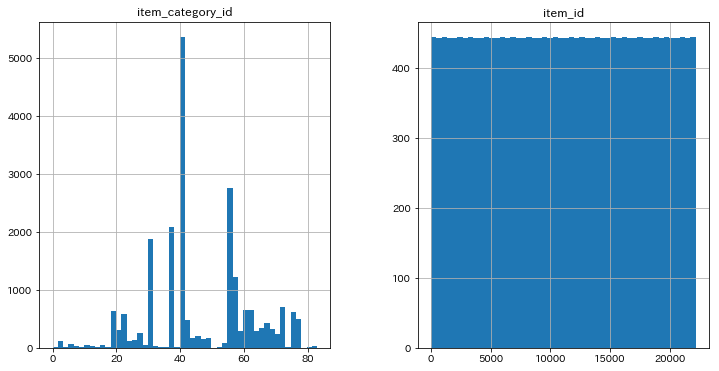

In [8]:
items_fig =  items.select_dtypes(include = ['float64', 'int64'])
items_fig.hist(figsize=(12, 6), bins=50, xlabelsize=10, ylabelsize=10)

4. Other data

In [6]:
print('\n# shops\n')
print("shape", shops.shape)
print('\n')
shops.info()
display(shops.head())
print('*'*100)

print('\n# item_cats\n')
print("shape", item_cats.shape)
print('\n')
item_cats.info()
display(item_cats.head())
print('*'*100)

print('\n# sample_subs\n')
print("shape", sample_subs.shape)
print('\n')
test.info()
display(sample_subs.head())
print('*'*100)


# shops

shape (60, 2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


****************************************************************************************************

# item_cats

shape (84, 2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


****************************************************************************************************

# sample_subs

shape (214200, 2)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 2 columns):
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(2)
memory usage: 4.9 MB


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


****************************************************************************************************


# Feature engineering and data cleaning

Outliers  
There are outliers in the item_price and item_cut_day.
I excluded these values.

(item_price < 10000,item_cut_day < 1100)

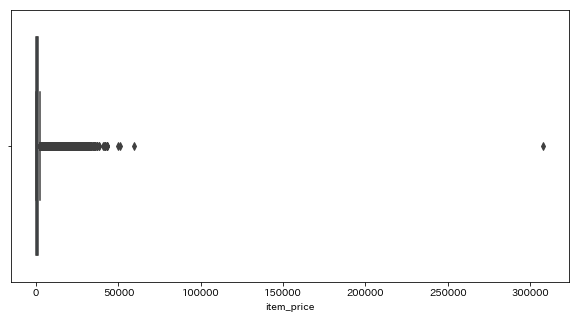

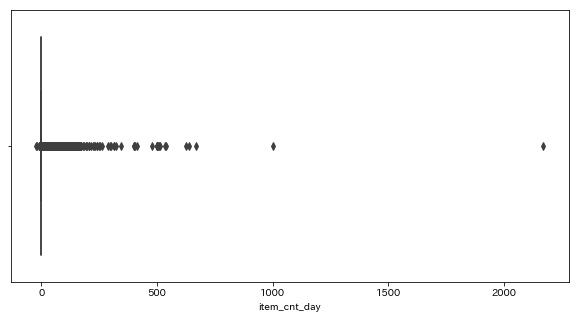

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train.item_price)

plt.figure(figsize=(10,5))
sns.boxplot(x=train.item_cnt_day)

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1100]

Check item_price less than 0

In [5]:
print(train[train.item_price < 0 ])

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0


Replace item_price less than 0 with the median

In [6]:
med = train[(train['date_block_num'] == 4)&(train['shop_id'] == 32)&
                  (train['item_id'] == 2973)&(train['item_price'] >0 )].item_price.median()
train.loc[train.item_price<0, 'item_price'] = med

In [7]:
print(train[train.item_price < 0 ])

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []


In [8]:
# Cheack shops.There are 60 shops in total.
print("shops.shaep",shops.shape)
display(shops)

shops.shaep (60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [9]:
# Unify duplicate shop_name to shop_ids.
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] == 57
test.loc[test.shop_id == 0, 'shop_id'] == 57

# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] == 58
test.loc[test.shop_id == 1, 'shop_id'] == 58

# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# Shop/Item_cat/Item preprocessing

The following can be seen from the observation of datas.

- Each shop_name starts with the city name.  
- Each category contains type and subtype in its name.

In [10]:
# shop_name
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

# LabelEncoder
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

shops = shops[['shop_id', 'city_code']]

In [11]:
print("shops.shaep",shops.shape)
shops.head()

shops.shaep (60, 2)


,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [12]:
# Cheack item_cats
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
# Split categroy with '-'
item_cats['split'] = item_cats['item_category_name'].str.split('-')
# For 'type', substitiute the first value splited by '-' .
item_cats['type'] = item_cats['split'].map(lambda x: x[0].strip())

item_cats['type_code'] = LabelEncoder().fit_transform(item_cats['type'])

# Some data does not have a subtype, so in that case, assign the type to the subtype.
item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) >1 else x[0].strip())
item_cats['subtype_code'] = LabelEncoder().fit_transform(item_cats['subtype'])

# Set shops structure to ['item_category_id', 'type_code', 'subtype_code']
item_cats = item_cats[['item_category_id','type_code', 'subtype_code']]

In [14]:
item_cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [15]:
# Observe items
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Since item_name has no information that is likely to be a feture value, the column is deleted.

In [16]:
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


# Aggregate data

In [65]:
del all_data

In [17]:
#ts = time.time()
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
#毎月、その月のすべてのショップ/アイテムの組み合わせからグリッドを作成します
grid = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train[train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    
#turn the grid into pandas dataframe
#グリッドをパンダのデータフレームに変える
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# #get aggregated values for (shop_id, item_id, month)
# #（shop_id、item_id、month）の集計値を取得します
# gb = train.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

# #fix column names
# gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
# #join aggregated data to the grid
# #集約されたデータをグリッドに結合する
# all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
# #sort the data
# all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
# print(time.time() - ts)

In [18]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [19]:
#get aggregated values for (shop_id, item_id, month)
#（shop_id、item_id、month）の集計値を取得します
gb = train.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}, 'item_price':{'item_price':'mean'}})

C:\Users\reEoN\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [20]:
gb.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price
,,,,target,item_price
0,0,30,1,31.0,265.0
1,0,31,1,11.0,434.0
2,0,32,0,6.0,221.0
3,0,32,1,10.0,221.0
4,0,33,0,3.0,347.0


In [21]:
gb[(gb['shop_id'] == 0) & (gb['item_id'] == 32) & (gb['date_block_num'] == 0)]

,shop_id,item_id,date_block_num,item_cnt_day,item_price
,,,,target,item_price
2,0,32,0,6.0,221.0


In [22]:
#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#集約されたデータをグリッドに結合する
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [23]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_price
139255,0,19,0,0.0,0.0
141495,0,27,0,0.0,0.0
144968,0,28,0,0.0,0.0
142661,0,29,0,0.0,0.0
138947,0,32,0,6.0,221.0


# Test data preprocessing

Append test data to matrix with next month's data_block_num

In [24]:
#latest month
train['date_block_num'].max()

33

In [25]:
# append next month
test['date_block_num'] = 34
# cast
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
#add to matrix
all_data = pd.concat([all_data, test], ignore_index=True, sort=False)
#Convert NaN to 0
all_data.fillna(0, inplace=True) #34 month

print('all_data shape: ',all_data.shape)

all_data shape:  (11128004, 5)


# Add Shop/Item_cat/Item feature

In [26]:
ts = time.time()
# Add Shop/Item_cat/Item features to matrix
all_data = pd.merge(all_data, shops, on=['shop_id'], how='left')
all_data = pd.merge(all_data, items, on=['item_id'], how='left')
all_data = pd.merge(all_data, item_cats, on=['item_category_id'], how='left')

# cast
all_data['city_code'] = all_data['city_code'].astype(np.int8)
all_data['item_category_id'] = all_data['item_category_id'].astype(np.int8)
all_data['type_code'] = all_data['type_code'].astype(np.int8)
all_data['subtype_code'] = all_data['subtype_code'].astype(np.int8)
print(time.time() - ts)
display(all_data)

4.7510621547698975


,shop_id,item_id,date_block_num,target,item_price,city_code,item_category_id,type_code,subtype_code
0,0,19,0,0.0,0.0,29,40,11,4
1,0,27,0,0.0,0.0,29,19,5,10
2,0,28,0,0.0,0.0,29,30,8,55
3,0,29,0,0.0,0.0,29,23,5,16
4,0,32,0,6.0,221.0,29,40,11,4
5,0,33,0,3.0,347.0,29,37,11,1
6,0,34,0,0.0,0.0,29,40,11,4
7,0,35,0,1.0,247.0,29,40,11,4
8,0,40,0,0.0,0.0,29,57,13,8
9,0,41,0,0.0,0.0,29,57,13,8


In [27]:
all_data[(all_data['shop_id'] == 59) & (all_data['item_id'] == 22154) & (all_data['item_category_id'] == 37)]

,shop_id,item_id,date_block_num,target,item_price,city_code,item_category_id,type_code,subtype_code
365172,59,22154,0,1.0,999.0,30,37,11,1
740899,59,22154,1,0.0,0.0,30,37,11,1
1122791,59,22154,2,0.0,0.0,30,37,11,1
1497462,59,22154,3,0.0,0.0,30,37,11,1
3010730,59,22154,7,0.0,0.0,30,37,11,1
3365147,59,22154,8,0.0,0.0,30,37,11,1
3734942,59,22154,9,0.0,0.0,30,37,11,1
4488706,59,22154,11,0.0,0.0,30,37,11,1
10242436,59,22154,30,0.0,0.0,30,37,11,1
10456971,59,22154,31,0.0,0.0,30,37,11,1


# Mean encoding

In [28]:
id_types = ['item_id', 'shop_id', 'item_category_id']
encoding_methods = [('item_price', np.mean, 'mean'), ('item_cnt_day', np.sum, 'sum'), ('item_cnt_day', np.mean, 'mean')]
train_with_item = pd.merge(train, items, on=['item_id'], how='left')

In [29]:
train_with_item.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [30]:
for id_type in id_types:
    for column_id, agg, agg_type in encoding_methods:
        new_df = train_with_item.groupby([id_type, 'date_block_num']).aggregate(agg).reset_index()[[column_id, id_type, 'date_block_num']]
        new_df.columns = [id_type + '_' + agg_type + '_' + column_id, id_type, 'date_block_num']
        all_data = pd.merge(all_data, new_df, on=['date_block_num', id_type], how='left')

In [31]:
all_data

,shop_id,item_id,date_block_num,target,item_price,city_code,item_category_id,type_code,subtype_code,item_id_mean_item_price,item_id_sum_item_cnt_day,item_id_mean_item_cnt_day,shop_id_mean_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_mean_item_price,item_category_id_sum_item_cnt_day,item_category_id_mean_item_cnt_day
0,0,19,0,0.0,0.0,29,40,11,4,28.000000,1.0,1.000000,531.262049,5578.0,1.163781,244.485942,33489.0,1.145902
1,0,27,0,0.0,0.0,29,19,5,10,2325.000000,7.0,1.000000,531.262049,5578.0,1.163781,1534.154310,8983.0,1.131788
2,0,28,0,0.0,0.0,29,30,8,55,549.000000,8.0,1.000000,531.262049,5578.0,1.163781,428.972112,22216.0,1.198080
3,0,29,0,0.0,0.0,29,23,5,16,2397.500000,4.0,0.666667,531.262049,5578.0,1.163781,1844.486615,4150.0,1.080167
4,0,32,0,6.0,221.0,29,40,11,4,338.110349,299.0,1.328889,531.262049,5578.0,1.163781,244.485942,33489.0,1.145902
5,0,33,0,3.0,347.0,29,37,11,1,488.517241,61.0,1.051724,531.262049,5578.0,1.163781,465.036007,6094.0,1.053414
6,0,34,0,0.0,0.0,29,40,11,4,140.888889,9.0,1.000000,531.262049,5578.0,1.163781,244.485942,33489.0,1.145902
7,0,35,0,1.0,247.0,29,40,11,4,390.709091,78.0,1.418182,531.262049,5578.0,1.163781,244.485942,33489.0,1.145902
8,0,40,0,0.0,0.0,29,57,13,8,219.250000,4.0,1.000000,531.262049,5578.0,1.163781,277.780085,1539.0,1.003914
9,0,41,0,0.0,0.0,29,57,13,8,222.555556,9.0,1.000000,531.262049,5578.0,1.163781,277.780085,1539.0,1.003914


# Mean encoding for item_id

In [32]:
ts = time.time()
item_target_enc_na = 0.3343 # default na replacement
# Expanding mean scheme
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id')['target'].cumcount()
all_data['item_target_enc'] = cumsum/cumcnt
all_data['item_target_enc'].fillna(item_target_enc_na, inplace=True)
corr = np.corrcoef(all_data['target'], all_data['item_target_enc'])[0][1]
print("time:", time.time() - ts)
print("corr:",corr)

time: 2.142482280731201
corr: 0.5083609162260907


# Mean encoding for shop_id

In [42]:
ts = time.time()
item_target_enc_na = 0.3343 # default na replacement
# Expanding mean scheme
cumsum = all_data.groupby('shop_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('shop_id')['target'].cumcount()
all_data['shop_id_enc'] = cumsum/cumcnt
all_data['shop_id_enc'].fillna(item_target_enc_na, inplace=True)
corr = np.corrcoef(all_data['target'],all_data['shop_id_enc'])[0][1]
print("time:", time.time() - ts)
print("corr:",corr)

time: 1.8744211196899414
corr: 0.07263813854002024


shop_id is not much corr.so we can drop that columns.

In [43]:
all_data.drop(columns='shop_id_enc', inplace=True)
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'city_code',
       'item_category_id', 'type_code', 'subtype_code',
       'item_id_mean_item_price', 'item_id_sum_item_cnt_day',
       'item_id_mean_item_cnt_day', 'shop_id_mean_item_price',
       'shop_id_sum_item_cnt_day', 'shop_id_mean_item_cnt_day',
       'item_category_id_mean_item_price', 'item_category_id_sum_item_cnt_day',
       'item_category_id_mean_item_cnt_day', 'item_target_enc'],
      dtype='object')

# Add Lag features

In [33]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'item_price',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_id_mean_item_price', 'item_id_sum_item_cnt_day',
       'item_id_mean_item_cnt_day', 'shop_id_mean_item_price',
       'shop_id_sum_item_cnt_day', 'shop_id_mean_item_cnt_day',
       'item_category_id_mean_item_price', 'item_category_id_sum_item_cnt_day',
       'item_category_id_mean_item_cnt_day', 'item_target_enc'],
      dtype='object')

In [5]:
lag_features = ['item_id_mean_item_price',
 'item_id_sum_item_cnt_day',
 'item_id_mean_item_cnt_day',
 'shop_id_mean_item_price',
 'shop_id_sum_item_cnt_day',
 'shop_id_mean_item_cnt_day',
 'item_category_id_mean_item_price',
 'item_category_id_sum_item_cnt_day',
 'item_category_id_mean_item_cnt_day',
 'target']

In [35]:
lags = [1,2,3,4,6,12]

In [36]:
ts = time.time()
for lag in lags:
    all_data_lags = all_data.copy()
    all_data_lags.date_block_num += lag
    all_data_lags = all_data_lags[['date_block_num', 'shop_id', 'item_id'] + lag_features]
    all_data_lags.columns = ['date_block_num', 'shop_id', 'item_id'] + [lag_feat + '_' + str(lag) + 'months_ago' for lag_feat in lag_features]
    all_data = pd.merge(all_data, all_data_lags, on=['date_block_num', 'shop_id', 'item_id'], how='left')
print("time:", time.time() - ts)

time: 155.1520175933838


In [37]:
ts = time.time()
for feature in all_data.columns:
    if 'item_cnt' in feature:
        all_data[feature] = all_data[feature].fillna(0)
    elif 'target' in feature:
        all_data[feature] = all_data[feature].fillna(0)
    elif 'item_price' in feature:
        all_data[feature] = all_data[feature].fillna(all_data[feature].median())
print("time:", time.time() - ts)

time: 8.684990406036377


In [38]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'item_price',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_id_mean_item_price', 'item_id_sum_item_cnt_day',
       'item_id_mean_item_cnt_day', 'shop_id_mean_item_price',
       'shop_id_sum_item_cnt_day', 'shop_id_mean_item_cnt_day',
       'item_category_id_mean_item_price', 'item_category_id_sum_item_cnt_day',
       'item_category_id_mean_item_cnt_day', 'item_target_enc',
       'item_id_mean_item_price_1months_ago',
       'item_id_sum_item_cnt_day_1months_ago',
       'item_id_mean_item_cnt_day_1months_ago',
       'shop_id_mean_item_price_1months_ago',
       'shop_id_sum_item_cnt_day_1months_ago',
       'shop_id_mean_item_cnt_day_1months_ago',
       'item_category_id_mean_item_price_1months_ago',
       'item_category_id_sum_item_cnt_day_1months_ago',
       'item_category_id_mean_item_cnt_day_1months_ago', 'target_1months_ago',
       'item_id_mean_item_price_2months_ago',
       'i

In [39]:
# only take recent data (year > 2013)
all_data = all_data[all_data['date_block_num'] > 12]
all_data.head()

,shop_id,item_id,date_block_num,target,item_price,city_code,item_category_id,type_code,subtype_code,item_id_mean_item_price,item_id_sum_item_cnt_day,item_id_mean_item_cnt_day,shop_id_mean_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_mean_item_price,item_category_id_sum_item_cnt_day,item_category_id_mean_item_cnt_day,item_target_enc,item_id_mean_item_price_1months_ago,item_id_sum_item_cnt_day_1months_ago,item_id_mean_item_cnt_day_1months_ago,shop_id_mean_item_price_1months_ago,shop_id_sum_item_cnt_day_1months_ago,shop_id_mean_item_cnt_day_1months_ago,item_category_id_mean_item_price_1months_ago,item_category_id_sum_item_cnt_day_1months_ago,item_category_id_mean_item_cnt_day_1months_ago,target_1months_ago,item_id_mean_item_price_2months_ago,item_id_sum_item_cnt_day_2months_ago,item_id_mean_item_cnt_day_2months_ago,shop_id_mean_item_price_2months_ago,shop_id_sum_item_cnt_day_2months_ago,shop_id_mean_item_cnt_day_2months_ago,item_category_id_mean_item_price_2months_ago,item_category_id_sum_item_cnt_day_2months_ago,item_category_id_mean_item_cnt_day_2months_ago,target_2months_ago,item_id_mean_item_price_3months_ago,item_id_sum_item_cnt_day_3months_ago,item_id_mean_item_cnt_day_3months_ago,shop_id_mean_item_price_3months_ago,shop_id_sum_item_cnt_day_3months_ago,shop_id_mean_item_cnt_day_3months_ago,item_category_id_mean_item_price_3months_ago,item_category_id_sum_item_cnt_day_3months_ago,item_category_id_mean_item_cnt_day_3months_ago,target_3months_ago,item_id_mean_item_price_4months_ago,item_id_sum_item_cnt_day_4months_ago,item_id_mean_item_cnt_day_4months_ago,shop_id_mean_item_price_4months_ago,shop_id_sum_item_cnt_day_4months_ago,shop_id_mean_item_cnt_day_4months_ago,item_category_id_mean_item_price_4months_ago,item_category_id_sum_item_cnt_day_4months_ago,item_category_id_mean_item_cnt_day_4months_ago,target_4months_ago,item_id_mean_item_price_6months_ago,item_id_sum_item_cnt_day_6months_ago,item_id_mean_item_cnt_day_6months_ago,shop_id_mean_item_price_6months_ago,shop_id_sum_item_cnt_day_6months_ago,shop_id_mean_item_cnt_day_6months_ago,item_category_id_mean_item_price_6months_ago,item_category_id_sum_item_cnt_day_6months_ago,item_category_id_mean_item_cnt_day_6months_ago,target_6months_ago,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,target_12months_ago
4836056,2,30,13,0.0,0.0,0,40,11,4,166.083333,24.0,1.000000,1420.204177,911.0,1.164962,261.256517,18467.0,1.115157,3.368613,169.000000,58.0,1.054545,1208.397169,890.0,1.072289,252.909797,22065.0,1.105627,0.0,167.256667,47.0,1.044444,1729.827302,1322.0,1.136715,257.766298,28598.0,1.163135,0.0,165.217391,46.0,1.000000,1350.696228,862.0,1.318043,253.212749,25433.0,1.187625,0.0,205.525000,24.0,1.000000,1359.687476,795.0,1.253943,247.543851,24173.0,1.168003,0.0,384.894737,19.0,1.000000,1062.700284,875.0,1.104798,234.470179,24130.0,1.102380,0.0,383.921877,861.0,2.271768,1062.437181,488.0,1.07489,252.174936,31649.0,1.178558,0.0
4836057,2,31,13,0.0,0.0,0,37,11,1,499.000000,14.0,1.000000,1420.204177,911.0,1.164962,410.838662,6019.0,1.039731,2.023723,499.000000,15.0,0.882353,1208.397169,890.0,1.072289,383.303063,7511.0,1.017199,0.0,499.000000,25.0,1.041667,1729.827302,1322.0,1.136715,415.529137,9959.0,1.049310,0.0,488.377778,27.0,1.000000,1350.696228,862.0,1.318043,451.941971,7420.0,1.065480,0.0,543.528000,25.0,1.000000,1359.687476,795.0,1.253943,460.037825,6950.0,1.063016,0.0,688.400000,25.0,1.000000,1062.700284,875.0,1.104798,375.982848,8680.0,1.051357,0.0,666.991044,628.0,1.863501,1062.437181,488.0,1.07489,494.550783,6307.0,1.092310,4.0
4836058,2,32,13,0.0,0.0,0,40,11,4,144.066667,48.0,1.066667,1420.204177,911.0,1.164962,261.256517,18

In [110]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
gc.collect();
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6291948 entries, 4836056 to 11128003
Data columns (total 79 columns):
shop_id                                            int32
item_id                                            int32
date_block_num                                     int32
target                                             float32
item_price                                         float32
city_code                                          int8
item_category_id                                   int8
type_code                                          int8
subtype_code                                       int8
item_id_mean_item_price                            float32
item_id_sum_item_cnt_day                           float32
item_id_mean_item_cnt_day                          float32
shop_id_mean_item_price                            float32
shop_id_sum_item_cnt_day                           float32
shop_id_mean_item_cnt_day                          float32
item_category

In [114]:
#all_data[(all_data['shop_id'] == 59) & (all_data['item_id'] == 22154) & (all_data['item_category_id'] == 37)]

In [6]:
# Drop some columns
unused_cols = lag_features[:-1] + ['item_price']

In [7]:
unused_cols

['item_id_mean_item_price',
 'item_id_sum_item_cnt_day',
 'item_id_mean_item_cnt_day',
 'shop_id_mean_item_price',
 'shop_id_sum_item_cnt_day',
 'shop_id_mean_item_cnt_day',
 'item_category_id_mean_item_price',
 'item_category_id_sum_item_cnt_day',
 'item_category_id_mean_item_cnt_day',
 'item_price']

In [10]:
# Clipping target values
all_data['target'] = all_data['target'].clip(0, 40)

# Split into training and validation sets


Test set is last date_block_num (34). We will validate on the month before that (33) and train on everything else

In [11]:
X_train = all_data[all_data['date_block_num'] < 33].drop(unused_cols, axis=1)
X_val = all_data[all_data['date_block_num'] == 33].drop(unused_cols, axis=1)
X_test = all_data[all_data['date_block_num'] == 34].drop(unused_cols, axis=1)

In [45]:
X_train.head()

,shop_id,item_id,date_block_num,target,city_code,item_category_id,type_code,subtype_code,item_target_enc,item_id_mean_item_price_1months_ago,item_id_sum_item_cnt_day_1months_ago,item_id_mean_item_cnt_day_1months_ago,shop_id_mean_item_price_1months_ago,shop_id_sum_item_cnt_day_1months_ago,shop_id_mean_item_cnt_day_1months_ago,item_category_id_mean_item_price_1months_ago,item_category_id_sum_item_cnt_day_1months_ago,item_category_id_mean_item_cnt_day_1months_ago,target_1months_ago,item_id_mean_item_price_2months_ago,item_id_sum_item_cnt_day_2months_ago,item_id_mean_item_cnt_day_2months_ago,shop_id_mean_item_price_2months_ago,shop_id_sum_item_cnt_day_2months_ago,shop_id_mean_item_cnt_day_2months_ago,item_category_id_mean_item_price_2months_ago,item_category_id_sum_item_cnt_day_2months_ago,item_category_id_mean_item_cnt_day_2months_ago,target_2months_ago,item_id_mean_item_price_3months_ago,item_id_sum_item_cnt_day_3months_ago,item_id_mean_item_cnt_day_3months_ago,shop_id_mean_item_price_3months_ago,shop_id_sum_item_cnt_day_3months_ago,shop_id_mean_item_cnt_day_3months_ago,item_category_id_mean_item_price_3months_ago,item_category_id_sum_item_cnt_day_3months_ago,item_category_id_mean_item_cnt_day_3months_ago,target_3months_ago,item_id_mean_item_price_4months_ago,item_id_sum_item_cnt_day_4months_ago,item_id_mean_item_cnt_day_4months_ago,shop_id_mean_item_price_4months_ago,shop_id_sum_item_cnt_day_4months_ago,shop_id_mean_item_cnt_day_4months_ago,item_category_id_mean_item_price_4months_ago,item_category_id_sum_item_cnt_day_4months_ago,item_category_id_mean_item_cnt_day_4months_ago,target_4months_ago,item_id_mean_item_price_6months_ago,item_id_sum_item_cnt_day_6months_ago,item_id_mean_item_cnt_day_6months_ago,shop_id_mean_item_price_6months_ago,shop_id_sum_item_cnt_day_6months_ago,shop_id_mean_item_cnt_day_6months_ago,item_category_id_mean_item_price_6months_ago,item_category_id_sum_item_cnt_day_6months_ago,item_category_id_mean_item_cnt_day_6months_ago,target_6months_ago,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,target_12months_ago
4836056,2,30,13,0.0,0,40,11,4,3.368613,169.000000,58.0,1.054545,1208.397169,890.0,1.072289,252.909797,22065.0,1.105627,0.0,167.256667,47.0,1.044444,1729.827302,1322.0,1.136715,257.766298,28598.0,1.163135,0.0,165.217391,46.0,1.000000,1350.696228,862.0,1.318043,253.212749,25433.0,1.187625,0.0,205.525000,24.0,1.000000,1359.687476,795.0,1.253943,247.543851,24173.0,1.168003,0.0,384.894737,19.0,1.000000,1062.700284,875.0,1.104798,234.470179,24130.0,1.102380,0.0,383.921877,861.0,2.271768,1062.437181,488.0,1.07489,252.174936,31649.0,1.178558,0.0
4836057,2,31,13,0.0,0,37,11,1,2.023723,499.000000,15.0,0.882353,1208.397169,890.0,1.072289,383.303063,7511.0,1.017199,0.0,499.000000,25.0,1.041667,1729.827302,1322.0,1.136715,415.529137,9959.0,1.049310,0.0,488.377778,27.0,1.000000,1350.696228,862.0,1.318043,451.941971,7420.0,1.065480,0.0,543.528000,25.0,1.000000,1359.687476,795.0,1.253943,460.037825,6950.0,1.063016,0.0,688.400000,25.0,1.000000,1062.700284,875.0,1.104798,375.982848,8680.0,1.051357,0.0,666.991044,628.0,1.863501,1062.437181,488.0,1.07489,494.550783,6307.0,1.092310,4.0
4836058,2,32,13,0.0,0,40,11,4,2.456998,144.710526,84.0,1.105263,1208.397169,890.0,1.072289,252.909797,22065.0,1.105627,1.0,147.994444,89.0,1.098765,1729.827302,1322.0,1.136715,257.766298,28598.0,1.163135,0.0,144.316456,81.0,1.025316,1350.696228,862.0,1.318043,253.212749,25433.0,1.187625,0.0,184.592593,58.0,1.074074,1359.687476,795.0,1.253943,247.543851,24173.0,1.168003,0.0,340.172727,72.0,1.090909,1062.700284,875.0,1.104798,234.470179,24130.0,1.102380,0.0,337.771930,208.0,1.216374,1062.437181,488.0,1.07489,252.174936,31649.

In [47]:
X_val.head()

,shop_id,item_id,date_block_num,target,city_code,item_category_id,type_code,subtype_code,item_target_enc,item_id_mean_item_price_1months_ago,item_id_sum_item_cnt_day_1months_ago,item_id_mean_item_cnt_day_1months_ago,shop_id_mean_item_price_1months_ago,shop_id_sum_item_cnt_day_1months_ago,shop_id_mean_item_cnt_day_1months_ago,item_category_id_mean_item_price_1months_ago,item_category_id_sum_item_cnt_day_1months_ago,item_category_id_mean_item_cnt_day_1months_ago,target_1months_ago,item_id_mean_item_price_2months_ago,item_id_sum_item_cnt_day_2months_ago,item_id_mean_item_cnt_day_2months_ago,shop_id_mean_item_price_2months_ago,shop_id_sum_item_cnt_day_2months_ago,shop_id_mean_item_cnt_day_2months_ago,item_category_id_mean_item_price_2months_ago,item_category_id_sum_item_cnt_day_2months_ago,item_category_id_mean_item_cnt_day_2months_ago,target_2months_ago,item_id_mean_item_price_3months_ago,item_id_sum_item_cnt_day_3months_ago,item_id_mean_item_cnt_day_3months_ago,shop_id_mean_item_price_3months_ago,shop_id_sum_item_cnt_day_3months_ago,shop_id_mean_item_cnt_day_3months_ago,item_category_id_mean_item_price_3months_ago,item_category_id_sum_item_cnt_day_3months_ago,item_category_id_mean_item_cnt_day_3months_ago,target_3months_ago,item_id_mean_item_price_4months_ago,item_id_sum_item_cnt_day_4months_ago,item_id_mean_item_cnt_day_4months_ago,shop_id_mean_item_price_4months_ago,shop_id_sum_item_cnt_day_4months_ago,shop_id_mean_item_cnt_day_4months_ago,item_category_id_mean_item_price_4months_ago,item_category_id_sum_item_cnt_day_4months_ago,item_category_id_mean_item_cnt_day_4months_ago,target_4months_ago,item_id_mean_item_price_6months_ago,item_id_sum_item_cnt_day_6months_ago,item_id_mean_item_cnt_day_6months_ago,shop_id_mean_item_price_6months_ago,shop_id_sum_item_cnt_day_6months_ago,shop_id_mean_item_cnt_day_6months_ago,item_category_id_mean_item_price_6months_ago,item_category_id_sum_item_cnt_day_6months_ago,item_category_id_mean_item_cnt_day_6months_ago,target_6months_ago,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,target_12months_ago
10675632,2,30,33,0.0,0,40,11,4,1.394790,119.000000,3.0,1.000000,1483.187718,822.0,1.217778,279.393699,6779.0,1.045658,0.0,129.000000,6.0,1.000000,1041.930622,942.0,1.114793,273.242103,8513.0,1.042110,0.0,129.000000,4.0,1.00,1276.980968,785.0,1.060811,273.251516,9283.0,1.052614,0.0,129.000000,4.0,1.00,1356.287508,804.0,1.093878,279.142252,9304.0,1.064409,0.0,169.000000,4.0,1.0,1408.05886,859.0,1.370016,281.630704,10683.0,1.108885,0.0,169.000000,13.0,1.000000,1570.245849,945.0,1.206897,263.751745,13639.0,1.088073,0.0
10675633,2,31,33,1.0,0,37,11,1,0.946560,194.666667,9.0,1.000000,1483.187718,822.0,1.217778,442.024659,2989.0,1.063701,0.0,214.358077,53.0,1.019231,1041.930622,942.0,1.114793,432.716766,3426.0,1.056755,0.0,415.666667,6.0,1.00,1276.980968,785.0,1.060811,437.546273,3291.0,1.020782,0.0,376.338125,10.0,1.25,1356.287508,804.0,1.093878,482.284358,3756.0,1.066742,0.0,417.835385,13.0,1.0,1408.05886,859.0,1.370016,532.065674,4670.0,1.156227,0.0,499.000000,8.0,1.000000,1570.245849,945.0,1.206897,484.982835,5074.0,1.078427,0.0
10675634,2,32,33,0.0,0,40,11,4,1.342412,149.000000,19.0,1.000000,1483.187718,822.0,1.217778,279.393699,6779.0,1.045658,0.0,148.714286,30.0,1.071429,1041.930622,942.0,1.114793,273.242103,8513.0,1.042110,1.0,149.000000,21.0,1.05,1276.980968,785.0,1.060811,273.251516,9283.0,1.052614,0.0,149.000000,26.0,1.04,1356.287508,804.0,1.093878,279.142252,9304.0,1.064409,0.0,149.000000,20.0,1.0,1408.05886,859.0,1.370016,281.630704,10683.0,1.108885,0.0,148.991667,37.0,1.027778,1570.245849,945.0,1.206897,263.751745,13639.0,1.088073,2.0
10675635,2,33,33,0.0,0,37,11,1,0.531777,196

In [48]:
X_test.head()

,shop_id,item_id,date_block_num,target,city_code,item_category_id,type_code,subtype_code,item_target_enc,item_id_mean_item_price_1months_ago,item_id_sum_item_cnt_day_1months_ago,item_id_mean_item_cnt_day_1months_ago,shop_id_mean_item_price_1months_ago,shop_id_sum_item_cnt_day_1months_ago,shop_id_mean_item_cnt_day_1months_ago,item_category_id_mean_item_price_1months_ago,item_category_id_sum_item_cnt_day_1months_ago,item_category_id_mean_item_cnt_day_1months_ago,target_1months_ago,item_id_mean_item_price_2months_ago,item_id_sum_item_cnt_day_2months_ago,item_id_mean_item_cnt_day_2months_ago,shop_id_mean_item_price_2months_ago,shop_id_sum_item_cnt_day_2months_ago,shop_id_mean_item_cnt_day_2months_ago,item_category_id_mean_item_price_2months_ago,item_category_id_sum_item_cnt_day_2months_ago,item_category_id_mean_item_cnt_day_2months_ago,target_2months_ago,item_id_mean_item_price_3months_ago,item_id_sum_item_cnt_day_3months_ago,item_id_mean_item_cnt_day_3months_ago,shop_id_mean_item_price_3months_ago,shop_id_sum_item_cnt_day_3months_ago,shop_id_mean_item_cnt_day_3months_ago,item_category_id_mean_item_price_3months_ago,item_category_id_sum_item_cnt_day_3months_ago,item_category_id_mean_item_cnt_day_3months_ago,target_3months_ago,item_id_mean_item_price_4months_ago,item_id_sum_item_cnt_day_4months_ago,item_id_mean_item_cnt_day_4months_ago,shop_id_mean_item_price_4months_ago,shop_id_sum_item_cnt_day_4months_ago,shop_id_mean_item_cnt_day_4months_ago,item_category_id_mean_item_price_4months_ago,item_category_id_sum_item_cnt_day_4months_ago,item_category_id_mean_item_cnt_day_4months_ago,target_4months_ago,item_id_mean_item_price_6months_ago,item_id_sum_item_cnt_day_6months_ago,item_id_mean_item_cnt_day_6months_ago,shop_id_mean_item_price_6months_ago,shop_id_sum_item_cnt_day_6months_ago,shop_id_mean_item_cnt_day_6months_ago,item_category_id_mean_item_price_6months_ago,item_category_id_sum_item_cnt_day_6months_ago,item_category_id_mean_item_cnt_day_6months_ago,target_6months_ago,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,target_12months_ago
10913804,5,5037,34,0.0,3,19,5,10,1.950845,1499.000000,25.0,1.000000,1030.721934,1052.0,1.090155,1681.477885,2443.0,1.041791,0.0,941.385173,110.0,1.428571,1034.784340,1092.0,1.148265,1358.810861,3979.0,1.273688,1.0,894.589833,119.0,1.190000,921.702970,1294.0,1.080134,1140.894671,4667.0,1.126207,3.0,1491.031837,54.0,1.102041,872.942408,991.0,1.070194,1429.864122,3178.0,1.036868,1.0,1542.868750,87.0,1.087500,958.609887,1012.0,1.143503,1419.183142,3392.0,1.061991,1.0,2569.619846,65.0,1.0,1175.319266,1445.0,1.235043,1800.733280,6134.0,1.144403,1.0
10913805,5,5320,34,0.0,3,55,13,2,0.334300,299.000000,0.0,0.000000,885.712018,0.0,0.000000,383.303063,0.0,0.000000,0.0,299.000000,0.0,0.000000,879.698959,0.0,0.000000,379.198810,0.0,0.000000,0.0,299.000000,0.0,0.000000,873.283205,0.0,0.000000,379.198810,0.0,0.000000,0.0,299.000000,0.0,0.000000,869.560652,0.0,0.000000,379.198810,0.0,0.000000,0.0,299.000000,0.0,0.000000,857.097977,0.0,0.000000,375.982848,0.0,0.000000,0.0,299.000000,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0
10913806,5,5233,34,0.0,3,19,5,10,1.656863,1199.000000,42.0,1.024390,1030.721934,1052.0,1.090155,1681.477885,2443.0,1.041791,1.0,711.705729,80.0,1.250000,1034.784340,1092.0,1.148265,1358.810861,3979.0,1.273688,3.0,712.152323,150.0,1.181102,921.702970,1294.0,1.080134,1140.894671,4667.0,1.126207,1.0,1198.986111,37.0,1.027778,872.942408,991.0,1.070194,1429.864122,3178.0,1.036868,0.0,790.034091,71.0,1.075758,958.609887,1012.0,1.143503,1419.183142,3392.0,1.061991,3.0,299.000000,0.0,0.0,813.186002,0.0,0.000000,364.058483,0.0,0.000000,0.0
10913807,5,5232,34,0.0,3,23,5,16

In [54]:
# save all_data
all_data.to_csv('all_data.csv',index=False)

In [60]:
del all_data
gc.collect();

In [56]:
X_test = X_test.reindex(columns=X_val.columns)
X_test = X_test.drop('target', 1)

In [24]:
X_train.to_csv('./data/X_train.csv', index=False)
X_val.to_csv('./data/X_val.csv', index=False)
X_test.to_csv('./data/X_test.csv', index=False)

# Reload training and testing date

In [14]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
from math import sqrt

In [12]:
X_train_features = X_train.drop('target', 1)
y_train = X_train['target']
X_val_features = X_val.drop('target', 1)
y_val = X_val['target']

In [15]:
best_3 = []
count = 0
best = None

# Hyperparameter tuning

In [16]:
def train(params):
    global best_3, count
    params['max_depth'] = int(params['max_depth'])

    train_set = xgb.DMatrix(X_train_features, label=y_train)
    validation_set = xgb.DMatrix(X_val_features, label=y_val)

    watchlist = [(train_set, 'train'), (validation_set, 'validation')]
    model = xgb.train(params, train_set, 500, evals=watchlist, verbose_eval=True, early_stopping_rounds=50)
    predictions = model.predict(validation_set, ntree_limit=model.best_iteration + 1)
    loss = sqrt(mean_squared_error(y_val, predictions))
    
    if loss not in [best_model['loss'] for best_model in best_3]:
        best_3.append({ 'model': model, 'loss': loss })
    
    best_3 = sorted(best_3, key=lambda x: x['loss'])[:3]
    count += 1
    
    print(count)
    print("Trained with:")
    print(params)
    print("Loss:")
    print(loss)
    return { 'loss': loss, 'status': STATUS_OK }

In [17]:
seed = 20

def optimize():
    global best
    
    space = {
             'max_depth' : hp.quniform('max_depth', 5, 9, 1),
             'eta' : hp.quniform('eta', 0.07, 0.1, 0.01),
             'gamma' : hp.quniform('gamma', 0.8, 1.1, 0.1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
             'eval_metric': 'rmse',
             'objective': 'reg:linear',
             'tree_method': 'exact',
             'silent' : 1,
             'seed': seed
             }

    trials = Trials()
    best = fmin(train, space, algo=tpe.suggest, max_evals=15, trials=trials)

    print(best)

In [18]:
ts = time.time()
optimize()
print("time:", time.time() - ts)

  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.38229	validation-rmse:1.35972      

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.

[1]	train-rmse:1.32201	validation-rmse:1.31221      

[2]	train-rmse:1.26587	validation-rmse:1.27147      

[3]	train-rmse:1.2188	validation-rmse:1.23704       

[4]	train-rmse:1.18006	validation-rmse:1.20732      

[5]	train-rmse:1.1436	validation-rmse:1.1837        

[6]	train-rmse:1.11105	validation-rmse:1.16223      

[7]	train-rmse:1.08271	validation-rmse:1.1456       

[8]	train-rmse:1.05908	validation-rmse:1.12966      

[9]	train-rmse:1.03833	validation-rmse:1.11668      

[10]	train-rmse:1.01895	validation-rmse:1.1063      

[11]	train-rmse:1.00249	validation-rmse:1.09717     

[12]	train-rmse:0.98891	validation-rmse:1.0897      

[13]	train-rmse:0.977376	validation-rmse:1.0835     

[14]	train-rmse:0.967134	validation-rmse:1.07803    

[15]	train-rmse:0.957155	validati

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.37186	validation-rmse:1.35038                                 

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                 

[1]	train-rmse:1.30219	validation-rmse:1.29606                                 

[2]	train-rmse:1.24119	validation-rmse:1.25225                                 

[3]	train-rmse:1.18972	validation-rmse:1.21564                                 

[4]	train-rmse:1.14399	validation-rmse:1.18446                                 

[5]	train-rmse:1.10549	validation-rmse:1.15931                                 

[6]	train-rmse:1.06925	validation-rmse:1.13797                                 

[7]	train-rmse:1.04249	validation-rmse:1.12092                                 

[8]	train-rmse:1.01844	validation-rmse:1.10747                                 

[9]	train-rmse:0.995207	validation-rmse:1.09458                                

[10]	train-rmse:

[99]	train-rmse:0.75971	validation-rmse:1.02171                                

[100]	train-rmse:0.759238	validation-rmse:1.02109                              

[101]	train-rmse:0.758312	validation-rmse:1.02112                              

[102]	train-rmse:0.75744	validation-rmse:1.02089                               

[103]	train-rmse:0.756872	validation-rmse:1.02102                              

[104]	train-rmse:0.756353	validation-rmse:1.02111                              

[105]	train-rmse:0.755994	validation-rmse:1.02107                              

[106]	train-rmse:0.754708	validation-rmse:1.01999                              

[107]	train-rmse:0.75425	validation-rmse:1.01994                               

[108]	train-rmse:0.753684	validation-rmse:1.01992                              

[109]	train-rmse:0.753191	validation-rmse:1.01986                              

[110]	train-rmse:0.752784	validation-rmse:1.0198                               

[111]	train-rmse:0.752006	va

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.39011	validation-rmse:1.3658                                    

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                   

[1]	train-rmse:1.33481	validation-rmse:1.32251                                   

[2]	train-rmse:1.2861	validation-rmse:1.28485                                    

[3]	train-rmse:1.23906	validation-rmse:1.25184                                   

[4]	train-rmse:1.20172	validation-rmse:1.22333                                   

[5]	train-rmse:1.16692	validation-rmse:1.20008                                   

[6]	train-rmse:1.13599	validation-rmse:1.17823                                   

[7]	train-rmse:1.10999	validation-rmse:1.16037                                   

[8]	train-rmse:1.08462	validation-rmse:1.14577                                   

[9]	train-rmse:1.06363	validation-rmse:1.13274                               

[190]	train-rmse:0.771846	validation-rmse:1.02022                                  

[191]	train-rmse:0.77164	validation-rmse:1.02028                                   

[192]	train-rmse:0.771352	validation-rmse:1.02029                                  

[193]	train-rmse:0.771203	validation-rmse:1.02041                                  

[194]	train-rmse:0.770611	validation-rmse:1.02026                                  

[195]	train-rmse:0.770471	validation-rmse:1.01989                                  

[196]	train-rmse:0.769996	validation-rmse:1.01959                                  

[197]	train-rmse:0.769761	validation-rmse:1.01954                                  

[198]	train-rmse:0.76928	validation-rmse:1.01941                                   

[199]	train-rmse:0.769042	validation-rmse:1.01963                                  

[200]	train-rmse:0.76855	validation-rmse:1.01953                                   

[201]	train-rmse:0.7685	validation-rmse:1.01955                  

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.37948	validation-rmse:1.35674                                     

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                     

[1]	train-rmse:1.31683	validation-rmse:1.3084                                      

[2]	train-rmse:1.2592	validation-rmse:1.26625                                      

[3]	train-rmse:1.20948	validation-rmse:1.22935                                     

[4]	train-rmse:1.1666	validation-rmse:1.19933                                      

[5]	train-rmse:1.12861	validation-rmse:1.17475                                     

[6]	train-rmse:1.09403	validation-rmse:1.15219                                     

[7]	train-rmse:1.06536	validation-rmse:1.1347                                      

[8]	train-rmse:1.04148	validation-rmse:1.11998                                     

[9]	train-rmse:1.01972	validation-rmse:1.10752           

[190]	train-rmse:0.719484	validation-rmse:1.01397                                  

[191]	train-rmse:0.719362	validation-rmse:1.01397                                  

[192]	train-rmse:0.719177	validation-rmse:1.01384                                  

[193]	train-rmse:0.718956	validation-rmse:1.01386                                  

[194]	train-rmse:0.718077	validation-rmse:1.01361                                  

[195]	train-rmse:0.717872	validation-rmse:1.01374                                  

[196]	train-rmse:0.717588	validation-rmse:1.01366                                  

[197]	train-rmse:0.717351	validation-rmse:1.0137                                   

[198]	train-rmse:0.716887	validation-rmse:1.01381                                  

[199]	train-rmse:0.716621	validation-rmse:1.01426                                  

[200]	train-rmse:0.716423	validation-rmse:1.01416                                  

[201]	train-rmse:0.715878	validation-rmse:1.01402                

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.37504	validation-rmse:1.35349                                    

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                    

[1]	train-rmse:1.30981	validation-rmse:1.30161                                    

[2]	train-rmse:1.24948	validation-rmse:1.25863                                    

[3]	train-rmse:1.20003	validation-rmse:1.22262                                    

[4]	train-rmse:1.1571	validation-rmse:1.19353                                     

[5]	train-rmse:1.12113	validation-rmse:1.16924                                    

[6]	train-rmse:1.08696	validation-rmse:1.14734                                    

[7]	train-rmse:1.06158	validation-rmse:1.13098                                    

[8]	train-rmse:1.03839	validation-rmse:1.1161                                     

[9]	train-rmse:1.01727	validation-rmse:1.10409                     

[192]	train-rmse:0.759486	validation-rmse:1.02477                                 

[193]	train-rmse:0.759331	validation-rmse:1.02492                                 

[194]	train-rmse:0.759105	validation-rmse:1.02491                                 

[195]	train-rmse:0.758665	validation-rmse:1.02473                                 

[196]	train-rmse:0.758351	validation-rmse:1.0247                                  

[197]	train-rmse:0.758338	validation-rmse:1.0247                                  

[198]	train-rmse:0.758184	validation-rmse:1.02468                                 

[199]	train-rmse:0.756965	validation-rmse:1.02286                                 

[200]	train-rmse:0.755926	validation-rmse:1.02331                                 

[201]	train-rmse:0.754869	validation-rmse:1.02332                                 

[202]	train-rmse:0.754525	validation-rmse:1.02223                                 

[203]	train-rmse:0.754404	validation-rmse:1.02256                           

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.37953	validation-rmse:1.35646                                    

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                    

[1]	train-rmse:1.3169	validation-rmse:1.30819                                     

[2]	train-rmse:1.25925	validation-rmse:1.26642                                    

[3]	train-rmse:1.20959	validation-rmse:1.22957                                    

[4]	train-rmse:1.16671	validation-rmse:1.19971                                    

[5]	train-rmse:1.12892	validation-rmse:1.17552                                    

[6]	train-rmse:1.09506	validation-rmse:1.15269                                    

[7]	train-rmse:1.06534	validation-rmse:1.13488                                    

[8]	train-rmse:1.04147	validation-rmse:1.12026                                    

[9]	train-rmse:1.02001	validation-rmse:1.10816                     

[192]	train-rmse:0.725712	validation-rmse:1.01912                                 

[193]	train-rmse:0.725137	validation-rmse:1.01859                                 

[194]	train-rmse:0.724943	validation-rmse:1.01847                                 

[195]	train-rmse:0.723936	validation-rmse:1.01744                                 

[196]	train-rmse:0.723777	validation-rmse:1.01741                                 

[197]	train-rmse:0.723537	validation-rmse:1.0173                                  

[198]	train-rmse:0.722911	validation-rmse:1.0171                                  

[199]	train-rmse:0.722556	validation-rmse:1.01705                                 

[200]	train-rmse:0.722229	validation-rmse:1.01702                                 

[201]	train-rmse:0.721798	validation-rmse:1.01717                                 

[202]	train-rmse:0.72164	validation-rmse:1.01711                                  

[203]	train-rmse:0.721424	validation-rmse:1.01706                           

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.37853	validation-rmse:1.35605                                    

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                    

[1]	train-rmse:1.31484	validation-rmse:1.30438                                    

[2]	train-rmse:1.25751	validation-rmse:1.26242                                    

[3]	train-rmse:1.21069	validation-rmse:1.22809                                    

[4]	train-rmse:1.17	validation-rmse:1.20014                                       

[5]	train-rmse:1.13605	validation-rmse:1.17637                                    

[6]	train-rmse:1.10404	validation-rmse:1.15587                                    

[7]	train-rmse:1.07967	validation-rmse:1.13948                                    

[8]	train-rmse:1.05797	validation-rmse:1.12538                                    

[9]	train-rmse:1.0382	validation-rmse:1.11481                      

[192]	train-rmse:0.798557	validation-rmse:1.02455                                 

[193]	train-rmse:0.798428	validation-rmse:1.02451                                 

[194]	train-rmse:0.797912	validation-rmse:1.02436                                 

[195]	train-rmse:0.797651	validation-rmse:1.02481                                 

[196]	train-rmse:0.79763	validation-rmse:1.02481                                  

[197]	train-rmse:0.797401	validation-rmse:1.02479                                 

[198]	train-rmse:0.796881	validation-rmse:1.02493                                 

[199]	train-rmse:0.796369	validation-rmse:1.02618                                 

[200]	train-rmse:0.795985	validation-rmse:1.0261                                  

[201]	train-rmse:0.795804	validation-rmse:1.02614                                 

[202]	train-rmse:0.795646	validation-rmse:1.0261                                  

[203]	train-rmse:0.795292	validation-rmse:1.02574                           

[386]	train-rmse:0.752621	validation-rmse:1.01262                                 

[387]	train-rmse:0.752301	validation-rmse:1.01263                                 

[388]	train-rmse:0.752128	validation-rmse:1.01261                                 

[389]	train-rmse:0.752066	validation-rmse:1.0126                                  

[390]	train-rmse:0.751933	validation-rmse:1.01255                                 

[391]	train-rmse:0.751836	validation-rmse:1.01263                                 

[392]	train-rmse:0.751767	validation-rmse:1.01265                                 

[393]	train-rmse:0.751344	validation-rmse:1.01213                                 

[394]	train-rmse:0.751122	validation-rmse:1.01204                                 

[395]	train-rmse:0.750968	validation-rmse:1.01202                                 

[396]	train-rmse:0.75086	validation-rmse:1.01207                                  

[397]	train-rmse:0.750727	validation-rmse:1.01207                           

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.38471	validation-rmse:1.36207                                     

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                     

[1]	train-rmse:1.32508	validation-rmse:1.31574                                     

[2]	train-rmse:1.27231	validation-rmse:1.27446                                     

[3]	train-rmse:1.22088	validation-rmse:1.24025                                     

[4]	train-rmse:1.17879	validation-rmse:1.21011                                     

[5]	train-rmse:1.13947	validation-rmse:1.18493                                     

[6]	train-rmse:1.10548	validation-rmse:1.1635                                      

[7]	train-rmse:1.0733	validation-rmse:1.14321                                      

[8]	train-rmse:1.04655	validation-rmse:1.12721                                     

[9]	train-rmse:1.02293	validation-rmse:1.1136            

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.38547	validation-rmse:1.36182                                     

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                     

[1]	train-rmse:1.32692	validation-rmse:1.31449                                     

[2]	train-rmse:1.27306	validation-rmse:1.27509                                     

[3]	train-rmse:1.22832	validation-rmse:1.24225                                     

[4]	train-rmse:1.1917	validation-rmse:1.21465                                      

[5]	train-rmse:1.15558	validation-rmse:1.18937                                     

[6]	train-rmse:1.12627	validation-rmse:1.16994                                     

[7]	train-rmse:1.09928	validation-rmse:1.15215                                     

[8]	train-rmse:1.07694	validation-rmse:1.13768                                     

[9]	train-rmse:1.05844	validation-rmse:1.12606           

[190]	train-rmse:0.807079	validation-rmse:1.02998                                  

[191]	train-rmse:0.806503	validation-rmse:1.02991                                  

[192]	train-rmse:0.806057	validation-rmse:1.0298                                   

[193]	train-rmse:0.805836	validation-rmse:1.02974                                  

[194]	train-rmse:0.805182	validation-rmse:1.02896                                  

[195]	train-rmse:0.804748	validation-rmse:1.02898                                  

[196]	train-rmse:0.80372	validation-rmse:1.02861                                   

[197]	train-rmse:0.803511	validation-rmse:1.02861                                  

[198]	train-rmse:0.803342	validation-rmse:1.02868                                  

[199]	train-rmse:0.802989	validation-rmse:1.02852                                  

[200]	train-rmse:0.802474	validation-rmse:1.02837                                  

[201]	train-rmse:0.802212	validation-rmse:1.02842                

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.40129	validation-rmse:1.37202                                     

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                     

[1]	train-rmse:1.34762	validation-rmse:1.33333                                     

[2]	train-rmse:1.30424	validation-rmse:1.29887                                     

[3]	train-rmse:1.26229	validation-rmse:1.26874                                     

[4]	train-rmse:1.22513	validation-rmse:1.24195                                     

[5]	train-rmse:1.19423	validation-rmse:1.2192                                      

[6]	train-rmse:1.16387	validation-rmse:1.19767                                     

[7]	train-rmse:1.13685	validation-rmse:1.17928                                     

[8]	train-rmse:1.11392	validation-rmse:1.16413                                     

[9]	train-rmse:1.09143	validation-rmse:1.15075           

[190]	train-rmse:0.78008	validation-rmse:1.02096                                   

[191]	train-rmse:0.779874	validation-rmse:1.02075                                  

[192]	train-rmse:0.779552	validation-rmse:1.02067                                  

[193]	train-rmse:0.779123	validation-rmse:1.01987                                  

[194]	train-rmse:0.778682	validation-rmse:1.01969                                  

[195]	train-rmse:0.778636	validation-rmse:1.01967                                  

[196]	train-rmse:0.77857	validation-rmse:1.01964                                   

[197]	train-rmse:0.778378	validation-rmse:1.01961                                  

[198]	train-rmse:0.778166	validation-rmse:1.01976                                  

[199]	train-rmse:0.777883	validation-rmse:1.01982                                  

[200]	train-rmse:0.777274	validation-rmse:1.01923                                  

[201]	train-rmse:0.777005	validation-rmse:1.01911                

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.38477	validation-rmse:1.36203                                      

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                      

[1]	train-rmse:1.32518	validation-rmse:1.31595                                      

[2]	train-rmse:1.27243	validation-rmse:1.27429                                      

[3]	train-rmse:1.22106	validation-rmse:1.23965                                      

[4]	train-rmse:1.17897	validation-rmse:1.20988                                      

[5]	train-rmse:1.13969	validation-rmse:1.18398                                      

[6]	train-rmse:1.10594	validation-rmse:1.16179                                      

[7]	train-rmse:1.07405	validation-rmse:1.14246                                      

[8]	train-rmse:1.04668	validation-rmse:1.12631                                      

[9]	train-rmse:1.02388	validation-rmse:1.1128  

[188]	train-rmse:0.688664	validation-rmse:1.01022                                   

[189]	train-rmse:0.687426	validation-rmse:1.00875                                   

[190]	train-rmse:0.686828	validation-rmse:1.00867                                   

[191]	train-rmse:0.686507	validation-rmse:1.00868                                   

[192]	train-rmse:0.686383	validation-rmse:1.00867                                   

[193]	train-rmse:0.686199	validation-rmse:1.00868                                   

[194]	train-rmse:0.685153	validation-rmse:1.00786                                   

[195]	train-rmse:0.684298	validation-rmse:1.00778                                   

[196]	train-rmse:0.684065	validation-rmse:1.0077                                    

[197]	train-rmse:0.683775	validation-rmse:1.00766                                   

[198]	train-rmse:0.683526	validation-rmse:1.0077                                    

[199]	train-rmse:0.683077	validation-rmse:1.00785     

[378]	train-rmse:0.637951	validation-rmse:1.00116                                   

[379]	train-rmse:0.63786	validation-rmse:1.00114                                    

[380]	train-rmse:0.637752	validation-rmse:1.00112                                   

[381]	train-rmse:0.637588	validation-rmse:1.0012                                    

[382]	train-rmse:0.63732	validation-rmse:1.00115                                    

[383]	train-rmse:0.637209	validation-rmse:1.00115                                   

[384]	train-rmse:0.636789	validation-rmse:1.00086                                   

[385]	train-rmse:0.636619	validation-rmse:1.00081                                   

[386]	train-rmse:0.636538	validation-rmse:1.00079                                   

[387]	train-rmse:0.636312	validation-rmse:1.00086                                   

[388]	train-rmse:0.636283	validation-rmse:1.00088                                   

[389]	train-rmse:0.636192	validation-rmse:1.00087     

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.38547	validation-rmse:1.36182                                     

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                     

[1]	train-rmse:1.32693	validation-rmse:1.31465                                     

[2]	train-rmse:1.27309	validation-rmse:1.27523                                     

[3]	train-rmse:1.22834	validation-rmse:1.24248                                     

[4]	train-rmse:1.19173	validation-rmse:1.21487                                     

[5]	train-rmse:1.15562	validation-rmse:1.18958                                     

[6]	train-rmse:1.12635	validation-rmse:1.16993                                     

[7]	train-rmse:1.09934	validation-rmse:1.15205                                     

[8]	train-rmse:1.07709	validation-rmse:1.13693                                     

[9]	train-rmse:1.05859	validation-rmse:1.12508           

[190]	train-rmse:0.806282	validation-rmse:1.02568                                  

[191]	train-rmse:0.806061	validation-rmse:1.02551                                  

[192]	train-rmse:0.805993	validation-rmse:1.0255                                   

[193]	train-rmse:0.805002	validation-rmse:1.02516                                  

[194]	train-rmse:0.804724	validation-rmse:1.02501                                  

[195]	train-rmse:0.804459	validation-rmse:1.02462                                  

[196]	train-rmse:0.804263	validation-rmse:1.02462                                  

[197]	train-rmse:0.804093	validation-rmse:1.0246                                   

[198]	train-rmse:0.804072	validation-rmse:1.0246                                   

[199]	train-rmse:0.80364	validation-rmse:1.02413                                   

[200]	train-rmse:0.803418	validation-rmse:1.02402                                  

[201]	train-rmse:0.803013	validation-rmse:1.02345                

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.38547	validation-rmse:1.36182                                     

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                     

[1]	train-rmse:1.32692	validation-rmse:1.31449                                     

[2]	train-rmse:1.27306	validation-rmse:1.27509                                     

[3]	train-rmse:1.22832	validation-rmse:1.24225                                     

[4]	train-rmse:1.1917	validation-rmse:1.21465                                      

[5]	train-rmse:1.15558	validation-rmse:1.18937                                     

[6]	train-rmse:1.12627	validation-rmse:1.16994                                     

[7]	train-rmse:1.09928	validation-rmse:1.15215                                     

[8]	train-rmse:1.07694	validation-rmse:1.13768                                     

[9]	train-rmse:1.05844	validation-rmse:1.12606           

[190]	train-rmse:0.801974	validation-rmse:1.01871                                  

[191]	train-rmse:0.801728	validation-rmse:1.01867                                  

[192]	train-rmse:0.801581	validation-rmse:1.01838                                  

[193]	train-rmse:0.801305	validation-rmse:1.01832                                  

[194]	train-rmse:0.801177	validation-rmse:1.01833                                  

[195]	train-rmse:0.801022	validation-rmse:1.01835                                  

[196]	train-rmse:0.8008	validation-rmse:1.01836                                    

[197]	train-rmse:0.800469	validation-rmse:1.0182                                   

[198]	train-rmse:0.799166	validation-rmse:1.0176                                   

[199]	train-rmse:0.798652	validation-rmse:1.01735                                  

[200]	train-rmse:0.798367	validation-rmse:1.01734                                  

[201]	train-rmse:0.798093	validation-rmse:1.01719                

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.38546	validation-rmse:1.36182                                     

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                     

[1]	train-rmse:1.32683	validation-rmse:1.31446                                     

[2]	train-rmse:1.2731	validation-rmse:1.27501                                      

[3]	train-rmse:1.2284	validation-rmse:1.24208                                      

[4]	train-rmse:1.19166	validation-rmse:1.21477                                     

[5]	train-rmse:1.1556	validation-rmse:1.18965                                      

[6]	train-rmse:1.12627	validation-rmse:1.17027                                     

[7]	train-rmse:1.09937	validation-rmse:1.15205                                     

[8]	train-rmse:1.07711	validation-rmse:1.13696                                     

[9]	train-rmse:1.05865	validation-rmse:1.1252            

[190]	train-rmse:0.808929	validation-rmse:1.03295                                  

[191]	train-rmse:0.808738	validation-rmse:1.03285                                  

[192]	train-rmse:0.808595	validation-rmse:1.03241                                  

[193]	train-rmse:0.807943	validation-rmse:1.03229                                  

[194]	train-rmse:0.807745	validation-rmse:1.03228                                  

[195]	train-rmse:0.807391	validation-rmse:1.03221                                  

[196]	train-rmse:0.807093	validation-rmse:1.03201                                  

[197]	train-rmse:0.806828	validation-rmse:1.03197                                  

[198]	train-rmse:0.806667	validation-rmse:1.03191                                  

[199]	train-rmse:0.806476	validation-rmse:1.03166                                  

[200]	train-rmse:0.806224	validation-rmse:1.03194                                  

[201]	train-rmse:0.806035	validation-rmse:1.03178                

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

C:\Users\reEoN\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	train-rmse:1.39207	validation-rmse:1.3677                                    

Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.


Will train until validation-rmse hasn't improved in 50 rounds.                   

[1]	train-rmse:1.33875	validation-rmse:1.32472                                   

[2]	train-rmse:1.29281	validation-rmse:1.28861                                   

[3]	train-rmse:1.24943	validation-rmse:1.25735                                   

[4]	train-rmse:1.21261	validation-rmse:1.23059                                   

[5]	train-rmse:1.17905	validation-rmse:1.20574                                   

[6]	train-rmse:1.14996	validation-rmse:1.18589                                   

[7]	train-rmse:1.1254	validation-rmse:1.16854                                    

[8]	train-rmse:1.10167	validation-rmse:1.15386                                   

[9]	train-rmse:1.08133	validation-rmse:1.1404                                

[194]	train-rmse:0.811099	validation-rmse:1.02754                                

[195]	train-rmse:0.81096	validation-rmse:1.02749                                 

[196]	train-rmse:0.810486	validation-rmse:1.0277                                 

[197]	train-rmse:0.810247	validation-rmse:1.02735                                

[198]	train-rmse:0.809886	validation-rmse:1.02763                                

[199]	train-rmse:0.809114	validation-rmse:1.02704                                

[200]	train-rmse:0.808875	validation-rmse:1.0275                                 

[201]	train-rmse:0.80834	validation-rmse:1.02746                                 

[202]	train-rmse:0.807827	validation-rmse:1.02735                                

[203]	train-rmse:0.807619	validation-rmse:1.02736                                

[204]	train-rmse:0.807253	validation-rmse:1.02714                                

[205]	train-rmse:0.807046	validation-rmse:1.02703                                

[206

[390]	train-rmse:0.767385	validation-rmse:1.02311                                

[391]	train-rmse:0.76722	validation-rmse:1.02321                                 

[392]	train-rmse:0.767143	validation-rmse:1.02322                                

[393]	train-rmse:0.766847	validation-rmse:1.02301                                

[394]	train-rmse:0.766563	validation-rmse:1.02297                                

[395]	train-rmse:0.766441	validation-rmse:1.023                                  

[396]	train-rmse:0.766319	validation-rmse:1.02271                                

[397]	train-rmse:0.766001	validation-rmse:1.02278                                

[398]	train-rmse:0.765935	validation-rmse:1.02277                                

[399]	train-rmse:0.765836	validation-rmse:1.02269                                

[400]	train-rmse:0.765718	validation-rmse:1.02267                                

[401]	train-rmse:0.765563	validation-rmse:1.02267                                

[402

15                                                                               
Trained with:                                                                    
{'eta': 0.08, 'eval_metric': 'rmse', 'gamma': 1.0, 'max_depth': 6, 'min_child_weight': 3.0, 'objective': 'reg:linear', 'seed': 20, 'silent': 1, 'tree_method': 'exact'}
Loss:                                                                            
1.0148286626044545                                                               
100%|██████████| 15/15 [9:24:33<00:00, 2395.20s/it, best loss: 1.000358360295161]
{'eta': 0.08, 'gamma': 1.0, 'max_depth': 9.0, 'min_child_weight': 2.0}
time: 33874.16741371155

In [28]:
import joblib

In [29]:
joblib.dump(best_3[0], 'model_1')
joblib.dump(best_3[1], 'model_2') 
joblib.dump(best_3[2], 'model_3')

['model_3']

In [30]:
best_3

[{'model': <xgboost.core.Booster at 0x1604bd9fac8>, 'loss': 1.000358360295161},
 {'model': <xgboost.core.Booster at 0x1604c3716d8>,
  'loss': 1.0067443608391817},
 {'model': <xgboost.core.Booster at 0x1604bd95b38>, 'loss': 1.009430004665527}]

# Reload models and test data

In [31]:
import joblib
import xgboost as xgb

In [33]:
X_val_features = pd.read_csv('./data/X_val.csv').drop('target', 1)
X_test_features = pd.read_csv('./data/X_test.csv').reindex(columns=X_val_features.columns)
raw_test = pd.read_csv('./data/test.csv')
best_3 = [
    joblib.load('./models/model_1'),
    joblib.load('./models/model_2'),
    joblib.load('./models/model_3'),
]

# Ensembling

In [36]:
def predict_test(model):
    test = xgb.DMatrix(X_test_features)
    return model.predict(test, ntree_limit = model.best_iteration + 1)

In [37]:
first_preds = predict_test(best_3[0]['model'])
second_preds = predict_test(best_3[1]['model'])
third_preds = predict_test(best_3[2]['model'])

In [39]:
final_preds = np.array([first_preds, second_preds, third_preds]).mean(axis=0)

# Results Submission

In [46]:
subs = raw_test.copy()

In [47]:
subs['item_cnt_month'] = final_preds.clip(0,20)

In [48]:
subs

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.376047
1,1,5,5320,0.344758
2,2,5,5233,1.079271
3,3,5,5232,0.401607
4,4,5,5268,0.375768
5,5,5,5039,0.578078
6,6,5,5041,0.469499
7,7,5,5046,0.157955
8,8,5,5319,0.868604
9,9,5,5003,0.320123


In [49]:
submission = subs[['ID', 'item_cnt_month']]
submission.head()

,ID,item_cnt_month
0,0,0.376047
1,1,0.344758
2,2,1.079271
3,3,0.401607
4,4,0.375768


In [51]:
submission.to_csv('./data/subs_xgb_ens_01.csv', index=False)